In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tabulate import tabulate
layers = tf.keras.layers

The code block below defines a few helper functions to visualize the results. You do not need to touch them. 

In [2]:
def plot_examples(X, Y, n=10):
    """ Plot the first n examples for each of the 10 classes in the CIFAR dataset X, Y """
    fig, axes = plt.subplots(n, 10, figsize=(10, n))
    for l in range(10):
        axes[0, l].set_title(cifar10_labels[l], fontsize="smaller")
        m = np.squeeze(Y) == l  # boolean mask: True for all images of label l
        for i in range(n):
            image = X[m][i].astype("uint8")  # imshow expects uint8
            ax = axes[i, l]
            ax.imshow(image, origin="upper")
            ax.set(xticks=[], yticks=[])
    return fig, ax


def plot_prediction(X, Y, Y_predict):
    """
    Plot image X along with predicted probabilities Y_predict.
    X: CIFAR image, shape = (32, 32, 3)
    Y: CIFAR label, one-hot encoded, shape = (10)
    Y_predict: predicted probabilities, shape = (10)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    # plot image
    ax1.imshow(X.astype("uint8"), origin="upper")
    ax1.set(xticks=[], yticks=[])

    # plot probabilities
    ax2.barh(np.arange(10), Y_predict, align="center")
    ax2.set(xlim=(0, 1), xlabel="Score", yticks=[])
    for i in range(10):
        c = "red" if (i == np.argmax(Y)) else "black"
        ax2.text(0.05, i, cifar10_labels[i].capitalize(), ha="left", va="center", color=c)



def plot_confusion(Y_true, Y_predict):
    """
    Plot confusion matrix
    Y_true:    array of true classifications (0-9), shape = (N)
    Y_predict: array of predicted classifications (0-9), shape = (N)
    """
    C = np.histogram2d(Y_true, Y_predict, bins=np.linspace(-0.5, 9.5, 11))[0]
    Cn = C / np.sum(C, axis=1)

    fig = plt.figure()
    plt.imshow(Cn, interpolation="nearest", vmin=0, vmax=1, cmap=plt.cm.YlGnBu)
    plt.colorbar()
    plt.xlabel("prediction")
    plt.ylabel("truth")
    plt.xticks(range(10), cifar10_labels, rotation="vertical")
    plt.yticks(range(10), cifar10_labels)
    for x in range(10):
        for y in range(10):
            plt.annotate("%i" % C[x, y], xy=(y, x), ha="center", va="center")



First we load and preprocess CIFAR-10 data. The imagages are 32x32 pixels and have three color channels (red, green blue). 

In [3]:

# X: images, Y: labels
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print("TRAIN: images, shape = ", x_train.shape)
print("TRAIN: labels, shape = ", y_train.shape)
print("TEST: images, shape = ", x_test.shape)
print("TEST: labels, shape = ", y_test.shape)

cifar10_labels = np.array([                                                                                                                                                                       
    'airplane',                                                                                                                                                                                   
    'automobile',                                                                                                                                                                                 
    'bird',                                                                                                                                                                                       
    'cat',                                                                                                                                                                                        
    'deer',                                                                                                                                                                                       
    'dog',                                                                                                                                                                                        
    'frog',                                                                                                                                                                                       
    'horse',                                                                                                                                                                                      
    'ship',                                                                                                                                                                                       
    'truck'])  

170498071/170498071 [==============================] - 4s 0us/step
TRAIN: images, shape =  (50000, 32, 32, 3)
TRAIN: labels, shape =  (50000, 1)
TEST: images, shape =  (10000, 32, 32, 3)
TEST: labels, shape =  (10000, 1)


(<Figure size 720x720 with 100 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f37a74e4510>)

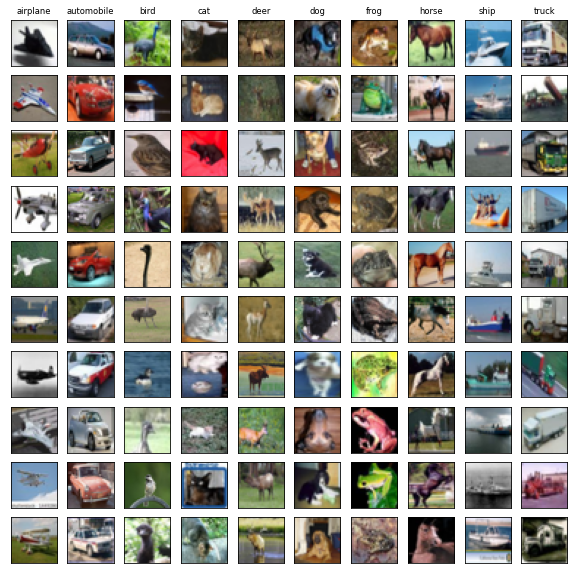

In [4]:
# Hint: To plot example images, you can use the plot examples function
plot_examples(x_train, y_train)

In [5]:
# convert labels ("0"-"9") to one-hot encodings, "0" = (1, 0, ... 0) and so on
y_train_onehot = tf.keras.utils.to_categorical(y_train, 10)
y_test_onehot = tf.keras.utils.to_categorical(y_test, 10)[:8000]
y_valid_onehot = tf.keras.utils.to_categorical(y_test, 10)[8000:]

# Hint: normalize the data
# Hint: use 20% of the testing data for validation

x_train_norm = x_train / 255.0
x_valid_norm = x_test[8000:] / 255.0
x_test_norm = x_test[:8000] / 255.0


## CNN
We classify the images with a CNN.


In [6]:
# Hint: this code snipped shows how to define convolution and maxpooling layers. For more information see 
# https://keras.io/api/layers/convolution_layers/convolution2d/
# https://keras.io/api/layers/pooling_layers/max_pooling2d/
model = tf.keras.models.Sequential(
    [
        layers.Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(10, activation = 'softmax')
    ],
    name="cnn",
)

print(model.summary())

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0       

In [7]:
# ----------------------------------------------------------
# Training
# ----------------------------------------------------------
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics=['accuracy'])

model.fit(
    x_train_norm, y_train_onehot,
    batch_size=64,
    epochs=20,
    validation_data=(x_valid_norm, y_valid_onehot),
    callbacks=[tf.keras.callbacks.CSVLogger("history_{}.csv".format(model.name))],
)

Epoch 1/20
782/782 [==============================] - 60s 75ms/step - loss: 1.6192 - accuracy: 0.4215 - val_loss: 1.3980 - val_accuracy: 0.5015
Epoch 2/20
782/782 [==============================] - 67s 86ms/step - loss: 1.3235 - accuracy: 0.5320 - val_loss: 1.2292 - val_accuracy: 0.5740
Epoch 3/20
782/782 [==============================] - 52s 66ms/step - loss: 1.2015 - accuracy: 0.5808 - val_loss: 1.1392 - val_accuracy: 0.5930
Epoch 4/20
782/782 [==============================] - 59s 75ms/step - loss: 1.1259 - accuracy: 0.6051 - val_loss: 1.1169 - val_accuracy: 0.6095
Epoch 5/20
782/782 [==============================] - 52s 66ms/step - loss: 1.0820 - accuracy: 0.6239 - val_loss: 1.0543 - val_accuracy: 0.6215
Epoch 6/20
782/782 [==============================] - 47s 60ms/step - loss: 1.0387 - accuracy: 0.6385 - val_loss: 1.0465 - val_accuracy: 0.6285
Epoch 7/20
782/782 [==============================] - 47s 60ms/step - loss: 1.0091 - accuracy: 0.6488 - val_loss: 1.0110 - val_accuracy:

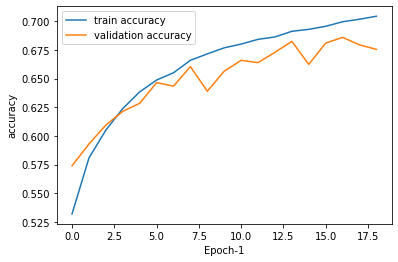

1563/1563 [==============================] - 21s 13ms/step - loss: 0.7386 - accuracy: 0.7477
accuracy for train dataset after training with CNN is 0.7477200031280518
63/63 [==============================] - 1s 12ms/step - loss: 0.9168 - accuracy: 0.6755
accuracy for val dataset after training with CNN is 0.6754999756813049
250/250 [==============================] - 3s 12ms/step - loss: 0.8803 - accuracy: 0.7017
accuracy for test dataset after training with CNN is 0.7017499804496765
63/63 [==============================] - 2s 32ms/step


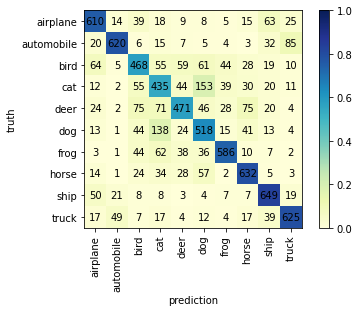

In [10]:
# ----------------------------------------------------------
# Plots
# ----------------------------------------------------------
# training curves plot
history = np.genfromtxt("history_{}.csv".format(model.name), delimiter=",", names=True)

train_acc = history["accuracy"][1:]
val_acc = history["val_accuracy"][1:]

plt.plot(train_acc, label = 'train accuracy')
plt.plot(val_acc, label = 'validation accuracy')
plt.legend()
plt.xlabel("Epoch-1")
plt.ylabel("accuracy")
plt.show()

# quote accuracies
print("accuracy for train dataset after training with CNN is", model.evaluate(x_train_norm, y_train_onehot)[1])
print("accuracy for val dataset after training with CNN is", model.evaluate(x_valid_norm, y_valid_onehot)[1])
print("accuracy for test dataset after training with CNN is", model.evaluate(x_test_norm, y_test_onehot)[1])

# calculate predictions for test set
y_predict = model.predict(x_test_norm, batch_size=128)

# convert back to class labels (0-9)
y_predict_cl = np.argmax(y_predict, axis=1)
y_test_cl = np.argmax(y_test_onehot, axis=1)

# plot confusion matrix
plot_confusion(y_test_cl, y_predict_cl)

In [ ]:
# Task: plot a few examples of correctly and incorrectly classified images. 
# Hint: First find the indices of correctly and incorrectly classified images:
m = y_predict_cl == y_test_cl
i0 = np.arange(8000)[~m]  # misclassified images
i1 = np.arange(8000)[m]  # correctly classified images

# original (unnormalized) test images
x_test = x_test[:8000]

# Hint: Now you can use the `plot_prediction` function to plot the images:
# plot first 10 false classifications
for i in i0[0:10]:
    plot_prediction(x_test[i], y_test_onehot[i], y_predict[i])

## CNN DenseNet
We classify the images with a CNN with DenseNet implementation using two dense block of 3 CNN layers each.

In [27]:
#layers = keras.layers

def dense_block(x, n=3):
  " Create a block of n densely connected pairs of convolutions "
  xlist = [x]
  for i in range(n):
    x = layers.Conv2D(8, (3, 3), padding='same', activation='relu')(x) 
    xlist.append(x)
    x = layers.concatenate(xlist[:], axis=-1)
  return x

x0 = tf.keras.Input(shape=(32, 32, 3), name = 'input')
x = dense_block(x0)
x = layers.Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D((2,2))(x)
x = dense_block(x)
x = layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D((2,2))(x)
print(x.shape)
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(10, activation = 'softmax')(x)

model = tf.keras.models.Model(inputs = [x0], outputs = [x], name="cnnDenseNet")
print(model.summary())

(None, 8, 8, 32)
Model: "cnnDenseNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_62 (Conv2D)             (None, 32, 32, 8)    224         ['input[0][0]']                  
                                                                                                  
 concatenate_45 (Concatenate)   (None, 32, 32, 11)   0           ['input[0][0]',                  
                                                                  'conv2d_62[0][0]']              
                                                                                                  
 conv2d_63 (Conv2D)             (None, 32, 32, 8)    800         ['conc

In [28]:
# ----------------------------------------------------------
# Training
# ----------------------------------------------------------
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics=['accuracy'])

model.fit(
    x_train_norm, y_train_onehot,
    batch_size=64,
    epochs=20,
    validation_data=(x_valid_norm, y_valid_onehot),
    callbacks=[tf.keras.callbacks.CSVLogger("history_{}.csv".format(model.name))],
)

Epoch 1/20
782/782 [==============================] - 286s 365ms/step - loss: 1.5285 - accuracy: 0.4509 - val_loss: 1.2362 - val_accuracy: 0.5595
Epoch 2/20
782/782 [==============================] - 291s 373ms/step - loss: 1.1565 - accuracy: 0.5928 - val_loss: 1.0726 - val_accuracy: 0.6160
Epoch 3/20
782/782 [==============================] - 294s 376ms/step - loss: 1.0136 - accuracy: 0.6432 - val_loss: 0.9657 - val_accuracy: 0.6570
Epoch 4/20
782/782 [==============================] - 292s 374ms/step - loss: 0.9269 - accuracy: 0.6770 - val_loss: 0.8953 - val_accuracy: 0.6825
Epoch 5/20
782/782 [==============================] - 293s 374ms/step - loss: 0.8645 - accuracy: 0.6975 - val_loss: 0.8453 - val_accuracy: 0.7030
Epoch 6/20
782/782 [==============================] - 294s 375ms/step - loss: 0.8198 - accuracy: 0.7138 - val_loss: 0.8345 - val_accuracy: 0.7045
Epoch 7/20
782/782 [==============================] - 292s 373ms/step - loss: 0.7867 - accuracy: 0.7254 - val_loss: 0.8220 -

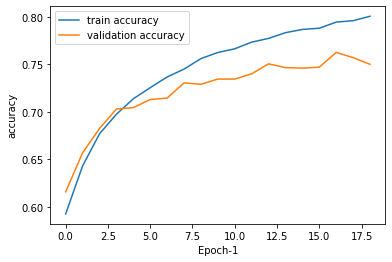

1563/1563 [==============================] - 67s 43ms/step - loss: 0.4511 - accuracy: 0.8462
accuracy for train dataset after training with CNN is 0.8462399840354919
63/63 [==============================] - 3s 43ms/step - loss: 0.7587 - accuracy: 0.7500
accuracy for val dataset after training with CNN is 0.75
250/250 [==============================] - 10s 42ms/step - loss: 0.7375 - accuracy: 0.7514
accuracy for test dataset after training with CNN is 0.7513750195503235
63/63 [==============================] - 9s 145ms/step


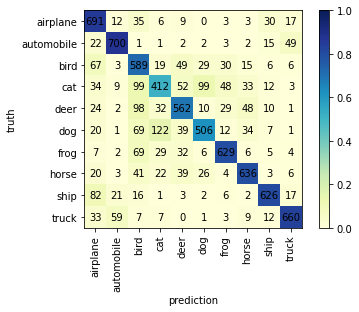

In [29]:
# ----------------------------------------------------------
# Plots
# ----------------------------------------------------------
# training curves plot
history = np.genfromtxt("history_{}.csv".format(model.name), delimiter=",", names=True)

train_acc = history["accuracy"][1:]
val_acc = history["val_accuracy"][1:]

plt.plot(train_acc, label = 'train accuracy')
plt.plot(val_acc, label = 'validation accuracy')
plt.legend()
plt.xlabel("Epoch-1")
plt.ylabel("accuracy")
plt.show()

# quote accuracies
print("accuracy for train dataset after training with CNN is", model.evaluate(x_train_norm, y_train_onehot)[1])
print("accuracy for val dataset after training with CNN is", model.evaluate(x_valid_norm, y_valid_onehot)[1])
print("accuracy for test dataset after training with CNN is", model.evaluate(x_test_norm, y_test_onehot)[1])

# calculate predictions for test set
y_predict = model.predict(x_test_norm, batch_size=128)

# convert back to class labels (0-9)
y_predict_cl = np.argmax(y_predict, axis=1)
y_test_cl = np.argmax(y_test_onehot, axis=1)

# plot confusion matrix
plot_confusion(y_test_cl, y_predict_cl)

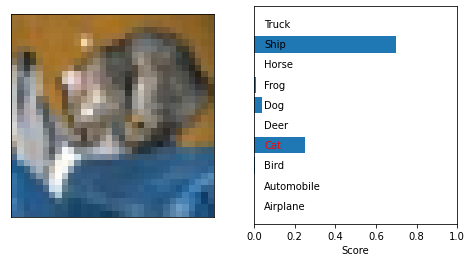

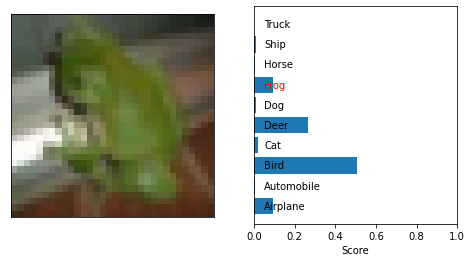

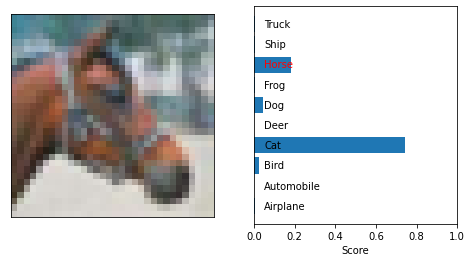

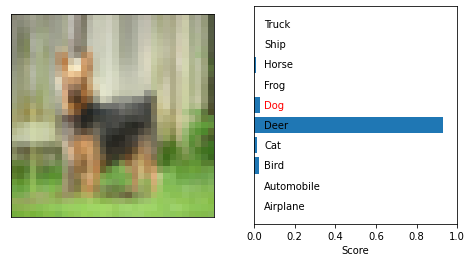

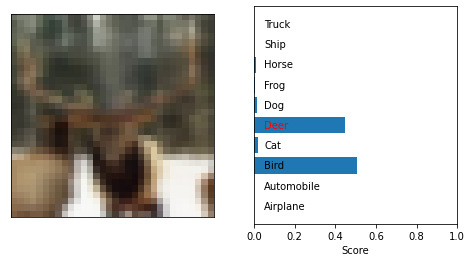

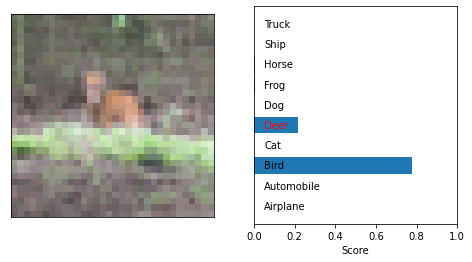

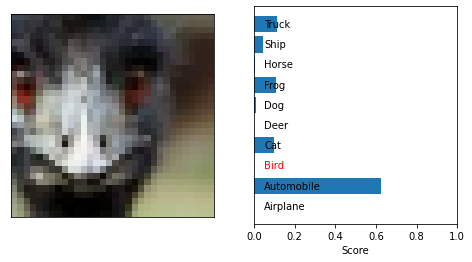

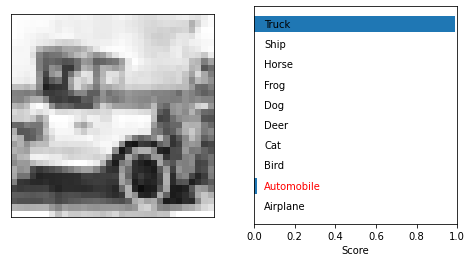

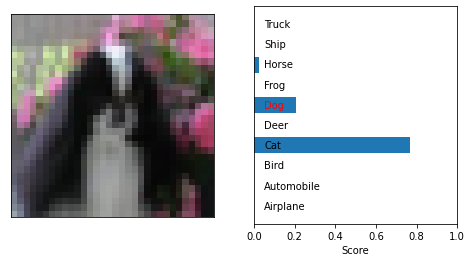

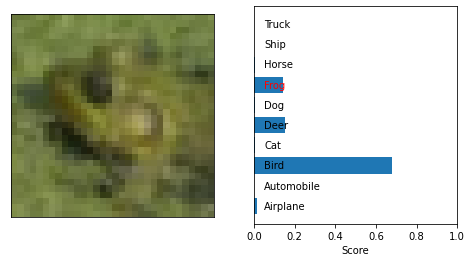

In [30]:
# Task: plot a few examples of correctly and incorrectly classified images. 
# Hint: First find the indices of correctly and incorrectly classified images:
m = y_predict_cl == y_test_cl
i0 = np.arange(8000)[~m]  # misclassified images
i1 = np.arange(8000)[m]  # correctly classified images

# original (unnormalized) test images
x_test = x_test[:8000]

# Hint: Now you can use the `plot_prediction` function to plot the images:
# plot first 10 false classifications
for i in i0[0:10]:
    plot_prediction(x_test[i], y_test_onehot[i], y_predict[i])

## Comments

Compared to standard CNN network, that obtained 70% accuracy, DenseNet network increases non-negligeably the accuracy with 75% obtained. It is worth to mention that this was obtained with the least recommended amount of Dense block, themself containing the least recommended number of CNN layers, for computanional time reasons. Hence, using a larger amount of the formers two could potentially increase even more the accuracy !

Quite powerful !